## Credit Card Fraud Detection Using GNNs

## Introduction

Fraud detection is the process of identifying and preventing unauthorized or suspicious activities, especially in industries like banking, finance, and e-commerce. In the context of credit card fraud detection, the goal is to identify fraudulent transactions while minimizing the impact on legitimate transactions. Given the financial and reputational risks involved, robust fraud detection systems are essential.


## Complex and evolving fraud patterns 

Fraudsters continually adapt their tactics, using sophisticated methods to evade detection. These often involve intricate networks of transactions designed to obscure fraudulent activities. Traditional rule-based systems and matrix-based machine learning models like SVMs and XGBoost typically analyze individual transactions (who transferred money to whom) but fail to capture the broader context of transaction patterns. Furthermore, rule-based systems require constant manual updates to keep up with emerging fraud strategies


## Challenges of Label Quality

One of the main challenges in credit card fraud detection is dealing with imbalanced and incompletely labeled datasets. Fraudulent transactions represent only a small fraction of total transactions. While domain experts label data points as either fraudulent or not, it is nearly impossible to identify all fraudulent instances, leading to noisy labels.

This class imbalance creates difficulties for supervised models, as training on imbalanced data often results in:

* **False negatives:** Fraudulent transactions misclassified as legitimate.

* **False positives:** Legitimate transactions wrongly flagged as fraud.

Graph Neural Networks (GNNs) address these issues by learning latent representations from transaction graphs and using them to identify hidden fraud patterns.


## Importance of Model Explainability

Simply predicting whether a transaction is fraudulent or not is insufficient, especially in sectors like banking, where transparency and accountability are crucial. It is important to explain why a model flagged a particular transaction as fraudulent. This allows investigators to:

* Understand how fraud occurs.

* Implement targeted anti-fraud measures.

* Ensure the model does not introduce biases.

Thus, fraud detection models must be interpretable, limiting the choice of models to those that balance predictive power with explainability.

## Graph-Based Approaches for Fraud Detection

Transactions can be naturally represented as a graph, where:

* Nodes represent users (credit card holders, merchants, etc.).

* Edges represent interactions (transactions between users).

Unlike traditional models that focus on node or edge features, graph-based methods leverage the graph structure, incorporating both local and global relationships between nodes.

In classic graph analytics, methods like the Louvain method and InfoMap help identify communities or clusters of users. However, these statistical methods often fail to capture dynamic or complex patterns.

Graph Neural Networks (GNNs) overcome this limitation by propagating information between nodes and edges through iterative message passing and aggregation. Multiple layers of graph convolution allow GNNs to capture long-range dependencies — essential for uncovering fraud chains that span multiple transactions

## Machine Learning on Graphs

The general pipeline for applying ML techniques to graphs involves the following steps:

* **Graph Representation:** Represent transactions as a graph using adjacency matrices, adjacency lists, or edge lists.

* **Feature Extraction:** Extract node and edge features such as transaction amounts, time intervals, or node degrees.

* **Dimensionality Reduction:** Apply techniques like PCA or t-SNE to reduce feature dimensionality, if needed.

* **Model Selection:** Choose suitable models like Graph Convolutional Networks (GCNs), Graph Attention Networks (GATs), or GraphSAGE.

* **Training and Evaluation:** Train models on labeled graph data and evaluate using metrics like precision, recall, and F1 score.

* **Prediction:** Use trained models to predict fraudulent nodes (users) or edges (transactions).

## Dataset

For this project, we use the IBM credit card transaction dataset — a publicly available, simulated dataset designed to reflect real-world transactions. The dataset contains:

* 24 million unique transactions

* 6,000 unique merchants

* 100,000 unique cards

* 30,000 fraudulent samples (0.1% of total transactions)

Due to the class imbalance, specialized techniques such as resampling, cost-sensitive learning, and GNN-based models are necessary.

**Data Source:**

* Download the dataset for local [use](https://ibm.ent.box.com/v/tabformer-data).

* Alternatively, access the dataset on [Kaggle](https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions).

##  Step 1: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

### Preprosessing 

Preprocessing tabular data before creating a graph is important because it ensures that the data is in a format that can be easily converted into a graph structure. Tabular data, such as a CSV file, typically contains rows and columns of information, with each row representing a single record and each column representing a specific feature or attribute. Before creating a graph, it is essential to clean and transform the data so that it is consistent and in a format that can be easily mapped to a graph structure. This may include tasks such as filling in missing values, converting data types, and removing duplicates.

Additionally, preprocessing tabular data can also help to improve the performance and accuracy of graph-based algorithms by reducing noise and irrelevant information in the data. This can be achieved by removing irrelevant features, normalizing numerical data, and encoding categorical data. Preprocessing can also help to balance the class distribution in case of imbalanced data, which is a common problem in fraud detection datasets.



In [2]:
os.chdir("../")
# Load the tabular dataset
df = pd.read_csv("artifacts\data_ingestion\credit_card_transactions-ibm_v2.csv")

In [3]:
df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


## Step 2: Data Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'Month'),
  Text(4, 0, 'User'),
  Text(5, 0, 'Card'),
  Text(6, 0, 'Year'),
  Text(7, 0, 'Amount'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Day'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Is Fraud?'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'Merchant Name'),
  Text(14, 0, 'MCC')])

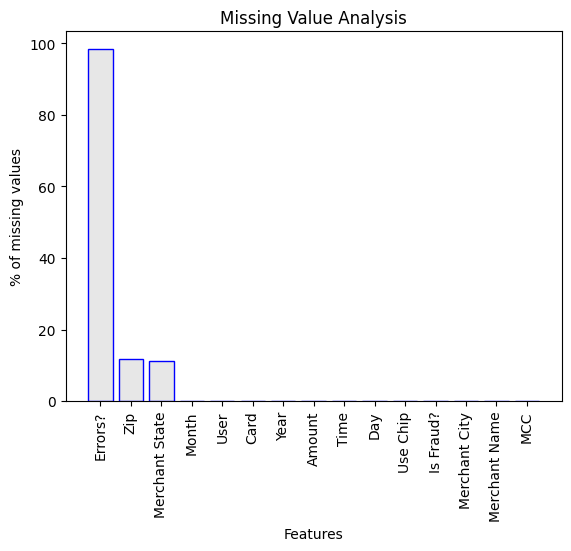

In [5]:
# Percentage of missing values
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

The card_id is defined as one card by one user. A specific user can have multiple cards, which would correspond to multiple different card_ids for this graph. 
For this reason we will create a new column which is the concatenation of the column User and the Column Card

In [6]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [7]:
df.Amount.head(5)

18199893      $59.18
9731325      $280.91
536687      $-144.00
13223840       $6.76
17070521       $9.17
Name: Amount, dtype: object

In [8]:
# We need to strip the ‘$’ from the Amount to cast as a float
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [9]:
# time can't be casted to int so so opted to extract the hour and minute
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [10]:
df.Hour

18199893    00
9731325     22
536687      07
13223840    14
17070521    11
            ..
3028639     20
11275290    14
1327632     11
2929345     09
4816941     11
Name: Hour, Length: 100000, dtype: object

In [11]:
df.Minute

18199893    11
9731325     12
536687      07
13223840    58
17070521    44
            ..
3028639     37
11275290    12
1327632     15
2929345     51
4816941     08
Name: Minute, Length: 100000, dtype: object

In [12]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            100000 non-null  int64  
 1   Month           100000 non-null  int64  
 2   Day             100000 non-null  int64  
 3   Amount          100000 non-null  float64
 4   Use Chip        100000 non-null  object 
 5   Merchant Name   100000 non-null  int64  
 6   Merchant City   100000 non-null  object 
 7   Merchant State  88782 non-null   object 
 8   Zip             88134 non-null   float64
 9   MCC             100000 non-null  int64  
 10  Errors?         1576 non-null    object 
 11  Is Fraud?       100000 non-null  object 
 12  card_id         100000 non-null  object 
 13  Hour            100000 non-null  object 
 14  Minute          100000 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 12.2+ MB


In [13]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance'], dtype=object)

In [14]:
df["Errors?"]= df["Errors?"].fillna("No error")

The two columns Zip and Merchant state contains missing values which can affect our graph. Moreover these information can be extracted from the column Merchant City so we will drop them.

In [15]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [16]:
# change the is fraud column to binary 
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [17]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [18]:
df["Errors?"].unique()

array([10,  6,  8, 11,  2,  0,  5,  7,  9,  3,  1,  4])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 18199893 to 4816941
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           100000 non-null  int64  
 1   Month          100000 non-null  int64  
 2   Day            100000 non-null  int64  
 3   Amount         100000 non-null  float64
 4   Use Chip       100000 non-null  int64  
 5   Merchant Name  100000 non-null  int64  
 6   Merchant City  100000 non-null  int64  
 7   MCC            100000 non-null  int64  
 8   Errors?        100000 non-null  int64  
 9   Is Fraud?      100000 non-null  int64  
 10  card_id        100000 non-null  object 
 11  Hour           100000 non-null  object 
 12  Minute         100000 non-null  object 
dtypes: float64(1), int64(9), object(3)
memory usage: 10.7+ MB
